In [1]:
from smartem import smartem,tools
from smartem.online import microscope,get_rescan_maps
from smartem.offline.train_mb_error_detector.NNtools import UNet
from smartem.segmentation import segmenter, utils
import h5py
import numpy as np
from skimage import io, measure
from pathlib import Path
import matplotlib.pyplot as plt
import pyvoi
import seaborn as sns
import pandas as pd
from tqdm import tqdm 
import torch

In [2]:
hdf5_path = "/storage2/projects/smartEM/em-vis/smartem-data-test.hdf5"
temp_dir = "/storage2/projects/smartEM/em-vis/temp/"

device = torch.device("cuda:1")

em2mb_model = UNet.UNet(1,2)
em2mb_path = "../../pretrained_models/em2mb_best.pth"

fast_dwt = 50
slow_dwt = 800
rescan_ratios = [0, 0.05, 0.1, 0.25, 0.5, 1.0]

In [3]:
Iseg = segmenter.Segmenter(em2mb_path, segmenter_function = measure.label, device=device)
Iseg.set_model(model_class=em2mb_model)

In [4]:
data_dwts = []
data_hdt_vois = []
data_gt_vois = []
data_re_ratio = []

with h5py.File(hdf5_path, 'r') as f:
    for rescan_ratio in tqdm(rescan_ratios, desc="varying rescan ratios..."):
        for reg in tqdm(f.keys(), desc="segmenting regions...", disable=True):
            group = f[reg]
            dwts = [int(dwt) for dwt in list(group.keys())]
            dwts.sort()
            slowest_dwt = dwts[-1]

            gt_mask = group[f"{slowest_dwt}/mask"][()]
            gt_labels = measure.label(255 - gt_mask)

            if gt_labels.shape[0] % 32 != 0:
                gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]
            #print(f"{gt_mask.shape}, {gt_mask.dtype} {np.amin(gt_mask)}-{np.amax(gt_mask)}")

            im = group[f"{slowest_dwt}/im"][()]
            hdt_labels = Iseg.get_labels(im)

            image_names = {}

            for dwt in dwts:
                im = group[f"{dwt}/im"][()]

                im_file_path = Path(temp_dir) / f"test_{reg}_{dwt}.png"
                io.imsave(im_file_path, im)
                image_names[dwt] = str(im_file_path)

            params = {"images_ns": image_names}
            my_microscope = microscope.FakeDataMicroscope(params=params)


            params = {
                "em2mb_net": em2mb_path,
                "error_net": "../../pretrained_models/error_best.pth",
                "device": device,
                "pad": 0,
                "rescan_p_thres": None, # 0.1
                "rescan_ratio":rescan_ratio,#add a number to force a specific rescan ratio
                "search_step": 0.01,
                #"do_clahe": False,
            }
            get_rescan_map = get_rescan_maps.GetRescanMapMembraneErrors(params=params)

            my_smart_em = smartem.SmartEM(
                microscope=my_microscope, get_rescan_map=get_rescan_map
            )

            my_smart_em.initialize()
            
            params = {"fast_dwt": fast_dwt*1e-9, "slow_dwt": slow_dwt*1e-9, "plot": False}
            fast_em, slow_em, rescan_map, *_ = my_smart_em.acquire(params=params)
            merged_em = fast_em.copy()
            merged_em[rescan_map] = slow_em[rescan_map]

            labels = Iseg.get_labels(merged_em)
        

            voi_gt,_,_ = pyvoi.VI(gt_labels.flatten(), labels.flatten())
            voi_hdt,_,_ = pyvoi.VI(hdt_labels.flatten(), labels.flatten())
            data_gt_vois.append(voi_gt.item())
            data_hdt_vois.append(voi_hdt.item())
            data_dwts.append(f"SmartEM: {fast_dwt}/{slow_dwt}ns")
            data_re_ratio.append(rescan_ratio)

data = {"Dwell Time (ns)": data_dwts, "Variation of Information from GT (nats)": data_gt_vois, "Variation of Information from 1200ns (nats)": data_hdt_vois, "Rescan Ratio": data_re_ratio}
df = pd.DataFrame(data=data)

varying rescan ratios...:   0%|          | 0/6 [00:00<?, ?it/s]

Inverting the image as not using custom watershed function


/home/tommy-local/projects/smartem/SmartEM/smartem/online/get_rescan_maps.py:149: UserWarning: This is very slow in the current implementation.
  warnings.warn("This is very slow in the current implementation.")


Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed functi

varying rescan ratios...:  17%|█▋        | 1/6 [01:48<09:03, 108.77s/it]

Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed functi

varying rescan ratios...:  33%|███▎      | 2/6 [03:36<07:12, 108.15s/it]

Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed functi

varying rescan ratios...:  50%|█████     | 3/6 [05:23<05:22, 107.53s/it]

Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed functi

varying rescan ratios...:  67%|██████▋   | 4/6 [07:09<03:34, 107.15s/it]

Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed functi

varying rescan ratios...:  83%|████████▎ | 5/6 [08:56<01:46, 106.88s/it]

Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed functi

varying rescan ratios...: 100%|██████████| 6/6 [10:42<00:00, 107.00s/it]


[Text(0.5, 1.0, 'SmartEM on Annotated Test (Held out) Data with 50/800ns Dwell Time')]

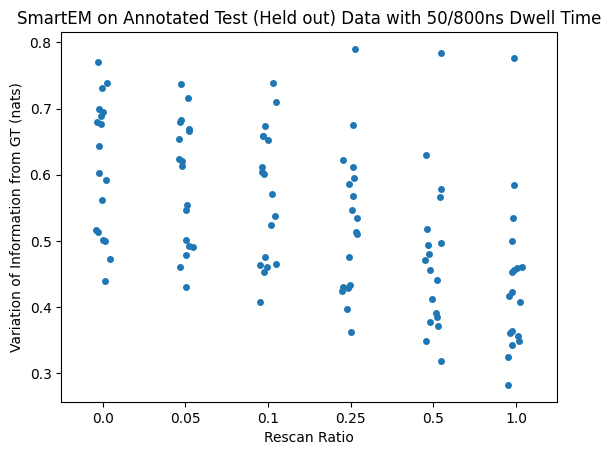

In [7]:
plot = sns.stripplot(data=df, y="Variation of Information from GT (nats)", x="Rescan Ratio")
plot.set(title='SmartEM on Test (Held out) Data with 50/800ns Dwell Time')

## Visualize

In [14]:
images = {}

with h5py.File(hdf5_path, 'r') as f:
    reg = list(f.keys())[2]

    group = f[reg]
    dwts = [int(dwt) for dwt in list(group.keys())]
    dwts.sort()
    slowest_dwt = dwts[-1]

    gt_mask = group[f"{slowest_dwt}/mask"][()]
    gt_labels = measure.label(255 - gt_mask)

    if gt_labels.shape[0] % 32 != 0:
        gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]
    gt_labels_shuffled = utils.shuffle_labels(gt_labels)
    gt_labels_masked = np.ma.masked_where(gt_labels_shuffled == 0, gt_labels_shuffled)

    gt_im = group[f"{slowest_dwt}/im"][()]
    hdt_labels = Iseg.get_labels(im)

    image_names = {}

    for dwt in dwts:
        im = group[f"{dwt}/im"][()]

        im_file_path = Path(temp_dir) / f"test_{reg}_{dwt}.png"
        io.imsave(im_file_path, im)
        image_names[dwt] = str(im_file_path)

    params = {"images_ns": image_names}
    my_microscope = microscope.FakeDataMicroscope(params=params)

    for rescan_ratio in tqdm(rescan_ratios, desc="varying rescan ratios..."):
        params = {
            "em2mb_net": em2mb_path,
            "error_net": "../../pretrained_models/error_best.pth",
            "device": device,
            "pad": 0,
            "rescan_p_thres": None, # 0.1
            "rescan_ratio":rescan_ratio,#add a number to force a specific rescan ratio
            "search_step": 0.01,
            #"do_clahe": False,
        }
        get_rescan_map = get_rescan_maps.GetRescanMapMembraneErrors(params=params)

        my_smart_em = smartem.SmartEM(
            microscope=my_microscope, get_rescan_map=get_rescan_map
        )

        my_smart_em.initialize()
        
        params = {"fast_dwt": fast_dwt*1e-9, "slow_dwt": slow_dwt*1e-9, "plot": False}
        fast_em, slow_em, rescan_map, *_ = my_smart_em.acquire(params=params)
        merged_em = fast_em.copy()
        merged_em[rescan_map] = slow_em[rescan_map]

        _, mb_probs = Iseg.get_membranes(merged_em, get_probs=True)
        labels = Iseg.get_labels(merged_em)

        labels_shuffled = utils.shuffle_labels(labels)
        labels_masked = np.ma.masked_where(labels_shuffled == 0, labels_shuffled)

        voi_gt,_,_ = pyvoi.VI(gt_labels.flatten(), labels.flatten())
    
        title_stem = f"rescan_ratio_{rescan_ratio}_VOI_{voi_gt.item():.2f}"

        images[title_stem + "_image"] = merged_em
        images[title_stem + "_label"] = labels_masked
        images[title_stem + "_pred"] = mb_probs


images["ground_truth_image"] = gt_im
images["ground_truth_label"] = gt_labels_masked
images["ground_truth_pred"] = gt_mask
images["high_dwell_time_image"] = gt_im


Inverting the image as not using custom watershed function


varying rescan ratios...:   0%|          | 0/6 [00:00<?, ?it/s]

Inverting the image as not using custom watershed function


varying rescan ratios...:  17%|█▋        | 1/6 [00:04<00:21,  4.37s/it]

Inverting the image as not using custom watershed function


varying rescan ratios...:  33%|███▎      | 2/6 [00:08<00:16,  4.13s/it]

Inverting the image as not using custom watershed function


varying rescan ratios...:  50%|█████     | 3/6 [00:12<00:12,  4.01s/it]

Inverting the image as not using custom watershed function


varying rescan ratios...:  67%|██████▋   | 4/6 [00:16<00:08,  4.12s/it]

Inverting the image as not using custom watershed function


varying rescan ratios...:  83%|████████▎ | 5/6 [00:20<00:04,  4.11s/it]

Inverting the image as not using custom watershed function


varying rescan ratios...: 100%|██████████| 6/6 [00:24<00:00,  4.09s/it]


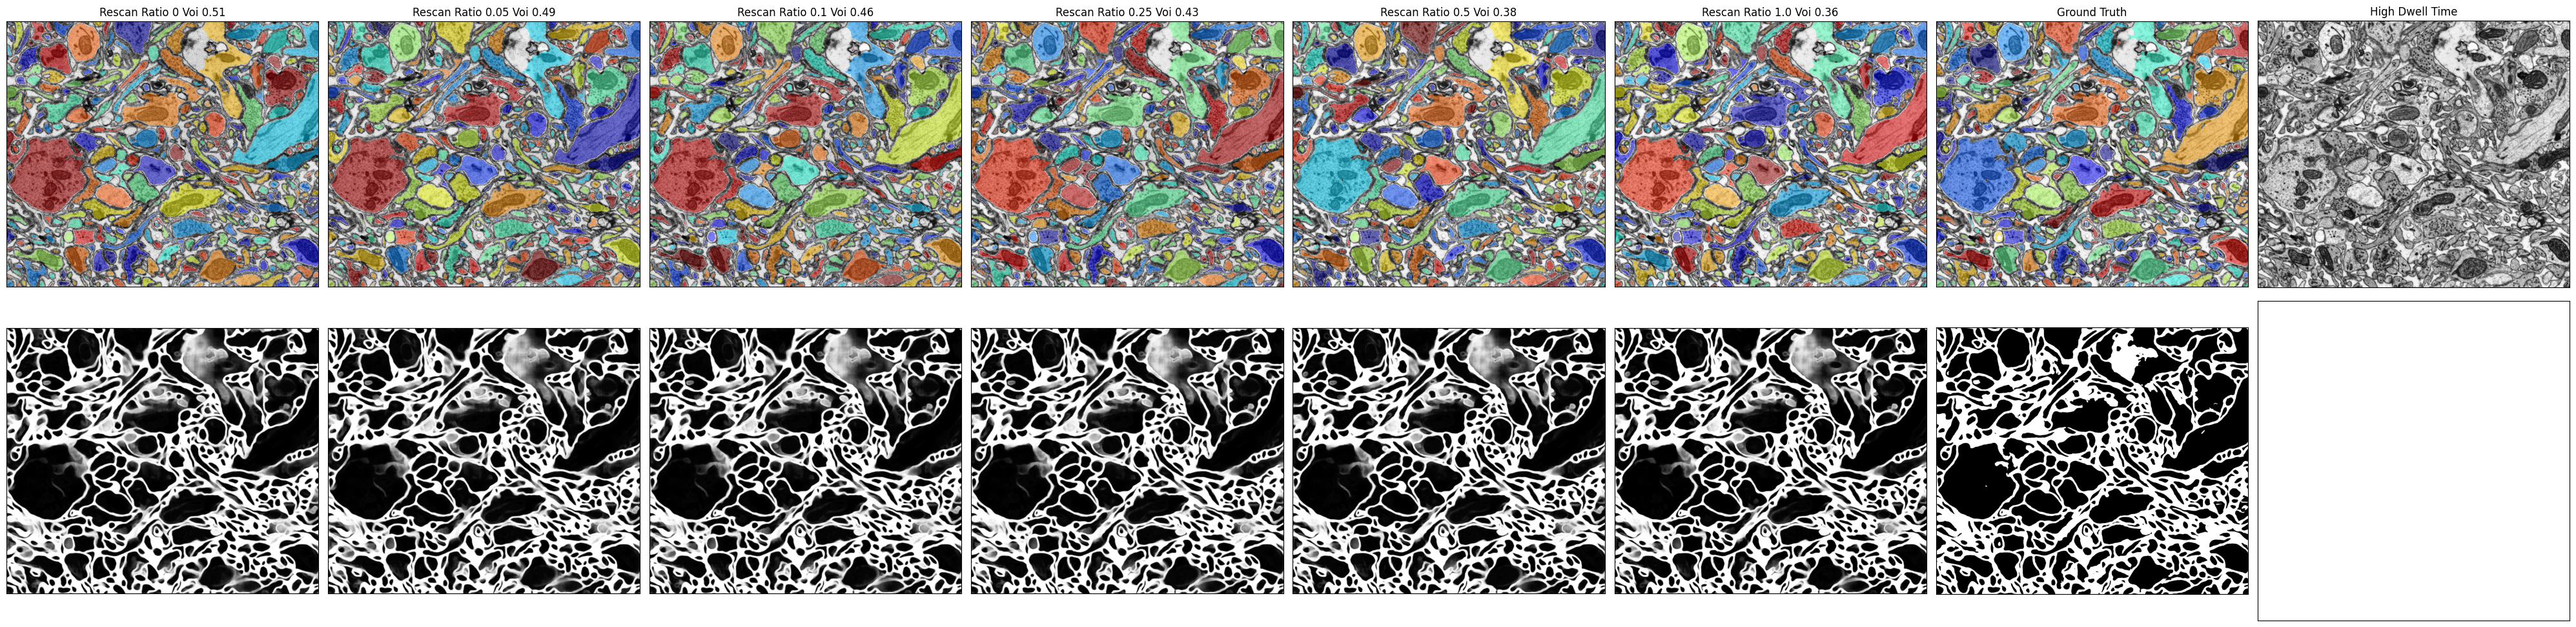

In [15]:
utils.visualize(**images)